We demonstrate that numerical integration can be more accurate than the numerical evaluation of the analytical integration result. We review floating point number representation and arithmetic, before breaking down integration into 3 possible methods, and analysing their relative merits. All work is done in an IPython notebook that can be downloaded from a link at the bottom of the article. "

## 1. Floating point representation and arithmetic

Floating point numbers, such as 0.1, 3.14 and 100.0 are generally represented approximately in a computer (see for example the  [Wikipedia entry on Floating Point](http://en.wikipedia.org/wiki/Floating_point) entry). Some of the numbers we care about can be represent exactly in this number scheme (such as 0.5, as it can be written as $\frac{1}{2} = 2^{-1}$ and thus expressed exactly in base 2), but other are only approximated, such as 0.1:

In [1]:
print("{:.20}".format(0.5))   # exact representation possible
print("{:.20}".format(0.1))   # approximation of 0.1 used

0.5
0.10000000000000000555


These inaccuracies (approximation errors) tend to be of the order of $10^{-16}$ for IEEE double floating point representation with 8 bytes). In other words, the (nowadays quasi) standard floating point number has about 15 significant digits.

However, there are further complications when we subtract two numbers (see also [Wikipedia: Loss of Significance](http://en.wikipedia.org/wiki/Loss_of_significance)). Here is an example: while $x$ and $y$ have 15 significant digits and the difference of the two should be $10^{-15}$, the value of $z = x - y$ has lost the vast majority of this significance:

In [2]:
x = 1.123456789012341000
y = 1.123456789012340000
z = x - y
print(z)

1.11022302463e-15


In [3]:
print("Relative error of z = {}".format((1e-15 - z)/1e-15))

Relative error of z = -0.110223024625


So the relative error is of the order of 10% -- that is very inaccurate.

The lesson is that subtraction of floating point numbers of similar magnitude leads to results that have a high relative error (or, equivalently, a small number of significant digits). This is referred to as *catastrophic cancellation*, when the reduction of significant digits is unacceptable.

The remainder of this blog entry focusses on this effect in evaluating integrals.

## 2. About the computation of $\int_a^b f(x) \mathrm{d}x$ using a computer

Assume we have some scalar function $f(x)$ depending on a scalar $x$ which we need to integrate to compute some number $c$:

$$c = \int_a^b f(x) \mathrm{d}x$$ 

We first review different methods of doing this, and then show some (maybe) suprising properties for special combinations of $f(x)$, and integration limits $a$ and $b$. In particular, we will look at $f(x)=x$ and $a$ and $b$ are both large, but $|b-a| \equiv \Delta x$ is small.

### 2.1 Method 1: Compute integral symbolically

If the function $f(x)$ is sufficiently simple, we can compute the antiderivative $F = \int f(x) \mathrm{dx}$ analytically. In the following code example, we will use the SYMbolic PYthon (sympy) package to attempt this, and in what follows we use the trivial function $f(x) = x$, which can be integrated analytically.

In [4]:
import sympy


def analytical_integral(f, a, b, verbose=True):
    """Compute \int_a^b f(x) dx symbolically. f, a and b can be 
    given as strings and will be converted into the exact number 
    using sympy's sympify method. The function f should depend 
    on 'x'. Returns a sympy object.
    
    Example: analytical_integral('x', 1, '1/10')
    """
    
    fsym = sympy.sympify(f)
    integral = sympy.simplify(sympy.integrate(fsym, ('x', a, b)))
   
    if verbose:
        print("Compute \int_{}^{} {} dx = {} = {} (exactly, using sympy)"\
              .format(a, b, fsym, integral, integral.evalf()))

    return integral

Let's test this integration for $c = \int_1^2 x \mathrm{dx}$, i.e. we use $f(x)=x$. Of course $F(x) = \frac{1}{2}x^2$, so that the analytical solution is known here:

In [5]:
print("%s" % analytical_integral('x', 1, '2'))

Compute \int_1^2 x dx = 3/2 = 1.50000000000000 (exactly, using sympy)
3/2


### 2.2 Method 2: Compute anti-derivative $F(x)$ symbolically, but evaluate the difference $F(b)-F(a)$ numerically:

In [6]:
import sympy
def evaluate_analytical_integral(f, a, b, verbose=True):
    """Compute antiderivative F(x) symbolically (so that 
    dF/dx(x) = f(x)), and evaluate F(b) - F(a) using 
    double floating point arithmetic. The parameters f, a 
    and b can be given as strings and will be converted 
    into the exact number using sympy's sympify method. 
    Return a float object."""
    
    fsym = sympy.sympify(f)
    Fsym = sympy.integrate(fsym)
    if verbose:
        print("Function we work on is {}, antiderivative is {}"\
              .format(fsym, Fsym))
    term1 = float(Fsym.subs('x', a).evalf(20))
    term2 = float(Fsym.subs('x', b).evalf(20))
    integral = term2 - term1   # this is where cancellation may 
                               # take place
    if verbose:
        print("Evaluate F(b)-F(a) as {:.16g} - {:.16g} = {:.16g} (in floats)"\
              .format(term2, term1, integral))
    return integral

In [7]:
evaluate_analytical_integral('x', 1, 2)

Function we work on is x, antiderivative is x**2/2
Evaluate F(b)-F(a) as 2 - 0.5 = 1.5 (in floats)


1.5

### 2.3 Method 3: Compute integral numerically (composite trapezoidal rule)

In [8]:
def comp_trapezoidal_rule(f, a, dx, nsubdiv=100):
    """Return the approximation of the integral \int_a^b f(x) dx using
    the composite trapezoidal rule with nsubdiv subdivisions.
    
    Expect f(x) to be python function, accepting a float x and 
    returning a float f(x).
    
    Equation as in 
    http://en.wikipedia.org/wiki/Trapezoidal_rule#Uniform_grid
    """
    s = f(a)
    for i in xrange(1, nsubdiv):
        x = a + i * dx / float(nsubdiv)
        s = s + 2 * f(x)
    s = s + f(a + dx)
    return s * dx / nsubdiv / 2.
    

In [9]:
comp_trapezoidal_rule(f=lambda x : x, a=1, dx=1)

1.4999999999999998

### 2.4 Introduce convenience function that COMPAREs the three approaches

In [10]:
def compare(f, a, dx):
    """Compute \int_a^b f(x) dx using different 
    methods, where b = a + dx."""
    
    # convert strings to sympy objects
    asym = sympy.sympify(a)         # this allows use of '1/10' 
                                    # for exact representation of 0.1
    dxsym = sympy.sympify(dx)
    bsym = asym + dxsym
    fsym = sympy.sympify(f)
    
    # and get doubles from this
    afloat = float(asym.evalf(20))
    bfloat = float(bsym.evalf(20))
    dxfloat = float(dxsym)
    # and a float python function
    ffloat = lambda x : float(fsym.subs('x', x))
    
    exact = analytical_integral(fsym, asym, bsym, verbose=False)
    evaluate_exact = evaluate_analytical_integral(fsym, afloat, bfloat,
                                                  verbose=False)
    num_int = comp_trapezoidal_rule(ffloat, afloat, dxfloat)
    rel_err_evaluate_exact = abs((exact - evaluate_exact)/exact)
    rel_err_num_int = abs((exact - num_int)/exact)
    
    print("Analytic        = {:23.16g}, rel.err = {:13.6}"\
          .format(float(exact.evalf(16)), 0.))
    print("Evaluate Exact  = {:23.16g}, rel.err = {:13.6e}"\
          .format(evaluate_exact, float(rel_err_evaluate_exact)))
    print("Num.integrated  = {:23.16g}, rel.err = {:13.6e}"\
          .format(float(num_int), float(rel_err_num_int.evalf(16))))
    
    return rel_err_evaluate_exact


### 2.5 Which method to use?

This is generally dictated by the problem: if we can use method 1 to (i) solve the integral analytically and (ii) combine $F(b)-F(a)$ into a single expression, then this is the exact and the preferred method.

The generally second best situation is that we can compute $F(x)$ analytically and evaluate $F(b)-F(a)$ numerically, as described in method 2.

The least preferred option is normally the numeric integration as outlined in method 3.

## Results

###3.1 First demo

We compute $\int_a^{a + \frac{1}{11}} x \mathrm{dx}$ for increasing $a$. Let's start with a data point where $a=1$, where we find a relative error of the integration result (using method 2) that is of the expected order of magnitude of $\approx 10^{-15}$.

Our attention is on the numerical error of method 2 (labelled "Evaluate exact" in the output below).

In [11]:
a='1'; dx = '1/11'
compare('x', a, dx)

Analytic        =     0.09504132231404959, rel.err =           0.0
Evaluate Exact  =     0.09504132231404949, rel.err =  1.022129e-15
Num.integrated  =     0.09504132231404962, rel.err =  2.920369e-16


1.02212924114946e-15

However, increasing $a$ to ten million (no other changes), results in a relative error of $\approx 10^{-8}$:

In [12]:
a='10000000'; dx = '1/11'
compare('x', a, dx)

Analytic        =       909090.9132231405, rel.err =           0.0
Evaluate Exact  =           909090.921875, rel.err =  9.517045e-09
Num.integrated  =       909090.9132231411, rel.err =  6.402843e-16


9.51704538059485e-9

The analytic result (method 1) is fully exact, and used as a reference. The 'Evaluate Exact' result is method 2, and we will focus on its error, which originates in the evaluation of $F(b)-F(a)$. 

The numerical integration data from method 3 is not particularly meaningful here: as our test function f(x) is linear, the composite trapezoidal rule should integrate it exactly (apart from floating point inaccuracies), and the error is therefore always expected to be low (no differences in the equation). If the function was not linear (for example $f(x)=x^2$), the error of method 3 would be larger, but this could be addressed through more integration points or a higher order integration method.

### 3.2 Study this systematically for $f(x)=x$

We compute $\int_a^{a + \frac{1}{11}} x \mathrm{dx}$ for increasing $a$, where $a = 10^p$ and $p$ grows from 0 to 20.

In [13]:
rel_errs = []
powers = range(0, 20, 1) 
for power in powers:
    a = 10**power
    print("\ncompute \int x dx, from a = {} to a+1/11".format(a))
    relerr = compare('x', a, '1/11')
    rel_errs.append(relerr)



compute \int x dx, from a = 1 to a+1/11
Analytic        =     0.09504132231404959, rel.err =           0.0
Evaluate Exact  =     0.09504132231404949, rel.err =  1.022129e-15
Num.integrated  =     0.09504132231404962, rel.err =  2.920369e-16

compute \int x dx, from a = 10 to a+1/11
Analytic        =      0.9132231404958677, rel.err =           0.0
Evaluate Exact  =      0.9132231404958731, rel.err =  5.835453e-15
Num.integrated  =      0.9132231404958684, rel.err =  7.294316e-16

compute \int x dx, from a = 100 to a+1/11
Analytic        =       9.095041322314049, rel.err =           0.0
Evaluate Exact  =       9.095041322314501, rel.err =  4.960886e-14
Num.integrated  =       9.095041322314053, rel.err =  3.906209e-16

compute \int x dx, from a = 1000 to a+1/11
Analytic        =       90.91322314049587, rel.err =           0.0
Evaluate Exact  =       90.91322314052377, rel.err =  3.068410e-13
Num.integrated  =       90.91322314049589, rel.err =  1.563123e-16

compute \int x dx, from a

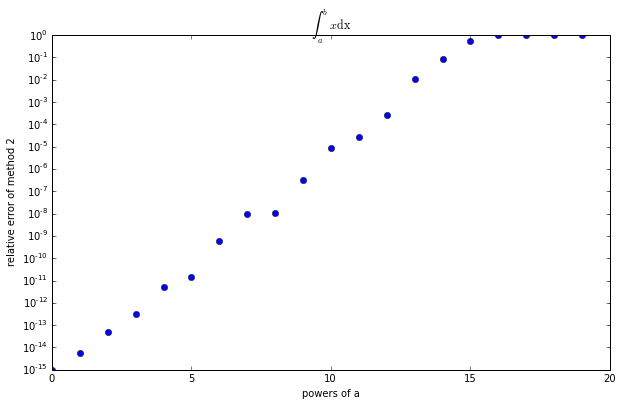

In [14]:
%matplotlib inline
import pylab
pylab.figure(figsize=(10,6))
pylab.semilogy(powers, rel_errs, 'o')
pylab.xlabel('powers of a')
pylab.ylabel('relative error of method 2')
pylab.title('$\int_a^b x \mathrm{dx}$')

We can see that the relative error of method 2 grows as the number $a$ increases. When $a\approx 10^{15}$ the relative error reaches 1 (=100%) as all digits in the difference computation $F(b)-F(a)$ have become insignificant (and the integration result computed using method 2 is 0, thus the relative error is 1).

### 3.3 Study this systematically for $f(x)=x^2$

We compute $\int_a^{a + \frac{1}{11}} x^2 \mathrm{dx}$ for increasing $a$, where $a = 10^p$ and $p$ grows from 0 to 20.

In [15]:
rel_errs = []
powers = range(0, 20, 1) 
for power in powers:
    a = 10**power
    print("\ncompute \int x^2 dx, from a = {} to a+1/11".format(a))
    relerr = compare('x**2', a, '1/11')
    rel_errs.append(relerr)


compute \int x^2 dx, from a = 1 to a+1/11
Analytic        =     0.09942399198597546, rel.err =           0.0
Evaluate Exact  =     0.09942399198597535, rel.err =  1.116655e-15
Num.integrated  =     0.09942400450788885, rel.err =  1.259446e-07

compute \int x^2 dx, from a = 10 to a+1/11
Analytic        =       9.173804157275232, rel.err =           0.0
Evaluate Exact  =       9.173804157275299, rel.err =  7.358077e-15
Num.integrated  =       9.173804169797146, rel.err =  1.364964e-09

compute \int x^2 dx, from a = 100 to a+1/11
Analytic        =       909.9176058101677, rel.err =           0.0
Evaluate Exact  =       909.9176058101584, rel.err =  1.024524e-14
Num.integrated  =       909.9176058226896, rel.err =  1.376148e-11

compute \int x^2 dx, from a = 1000 to a+1/11
Analytic        =       90917.35562233909, rel.err =           0.0
Evaluate Exact  =       90917.35562235117, rel.err =  1.328469e-13
Num.integrated  =       90917.35562235164, rel.err =  1.379687e-13

compute \int x^2 

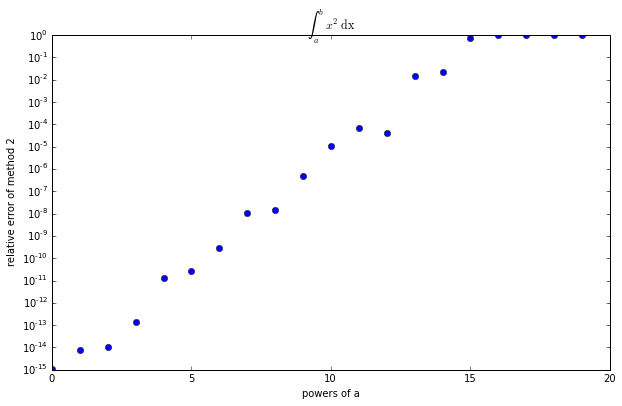

In [16]:
pylab.figure(figsize=(10,6))
pylab.semilogy(powers, rel_errs, 'o')
pylab.xlabel('powers of a')
pylab.ylabel('relative error of method 2')
pylab.title('$\int_a^b x^2 \mathrm{dx}$')

This second example, where we integrate $f(x)=x^2$ is meant to further demonstrate that the error of the method 3 (numerical integration) does not suffer this increasing error as the integration limit $a$ increases, even if the function is not entirely trivial (as was $f(x)=x$ in 3.2).

## 4. Summary

The main point we are trying to bring across here is that there can be situations in which (numerically) *evaluating* the exact integral (method 2) can be much less exact than full numerical integration (method 3).

This originates from catastrophic cancellation of similarly large numbers: in the constructed example above, this comes from $a$ and $b$ being very large and similar, and by using a linear function $f(x)$, this difference translates directly into $F(b)-F(a)$. What matters is of course the difference between similarly large numbers $F(a)$ and $F(b)$: other, and less artificial, integration limits $a$ and $b$ can translate into such a difference for other functions $f(x)$.

The numerical integration does not suffer from this problem as the approximation of the integral is computing using a sum (no differences).

------------------

A real-life example where this matters is the computation of the demagnetisation tensor in finite difference micromagnetic simulations. The [recent work by Dmitri Chernyshenko](2015-computing-the-demag-tensor-for-finite-difference-micromagnetic-simulations.html) shows how numerical integration provides highest accuracy of the demag tensor entries for intermediate distances - for exactly the reasons outlined above.

--------------------

 Download [this notebook](Research/2015-catastrophic-cancellation.ipynb).